<a href="https://colab.research.google.com/github/merlyn257/covid-classifier-model/blob/main/COVID_CT_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KERAS CNN CLASSIFICATION MODEL FOR COVID-19**

---



### Installing syft package to use PATE and importing other libraries


In [ ]:
!pip install syft

     |████████████████████████████████| 440kB 4.9MB/s 
     |████████████████████████████████| 4.0MB 11.1MB/s 
     |████████████████████████████████| 1.8MB 51.4MB/s 
     |████████████████████████████████| 2.0MB 51.8MB/s 
     |████████████████████████████████| 2.2MB 51.5MB/s 
     |████████████████████████████████| 9.0MB 20.5MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 204kB 51.1MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 753.4MB 24kB/s 
     |████████████████████████████████| 133kB 51.7MB/s 
     |████████████████████████████████| 450kB 45.6MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 491kB 48.7MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
    

In [ ]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, Subset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import time, os, random

# libary from pysyft needed to perform pate analysis
from syft.frameworks.torch.dp import pate

# we'll train on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Merlyn Joseph/Colab Notebooks/COVID/'

Mounted at /content/drive
/content/drive/My Drive/Merlyn Joseph/Colab Notebooks/COVID


### Creating Teacher and Student Datasets

In [ ]:
# Custom dataset
#from https://github.com/UCSD-AI4H/COVID-CT/blob/master/baseline methods/DenseNet169/DenseNet_predict.py
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform
        
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label = int(self.img_list[idx][1])
        return image, label

def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data


In [ ]:
batchsize=16
path = './data/images'

# Transforms used for datasets
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# divided among teachers
trainset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/trainCT_NonCOVID.txt',
                              transform= data_transforms)

# used as student valid set    
validset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/valCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/valCT_NonCOVID.txt',
                              transform= data_transforms)

# used as student train set    
testset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='./data/labels/COVID/testCT_COVID.txt',
                              txt_NonCOVID='./data/labels/NonCOVID/testCT_NonCOVID.txt',
                              transform= data_transforms)

print("Number of Classes: ",len(trainset.classes))
len(trainset), len(testset), len(validset)

Number of Classes:  2


(425, 203, 118)

 Image Size torch.Size([16, 3, 224, 224])
 Image Size torch.Size([3, 224, 224])


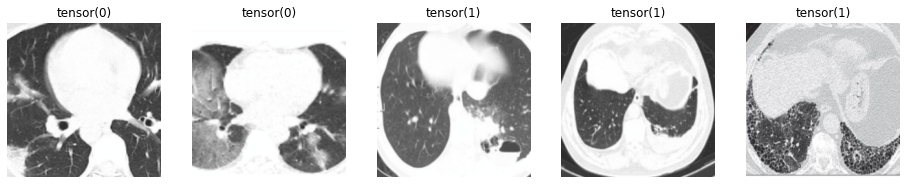

In [ ]:
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

# Displaying Images and other info about the train set
ii=0
images, labels = next(iter(data_loader))
print(" Image Size",images.size())
print(" Image Size",images[ii].size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

In [ ]:
# TEACHERS
#divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 32

def teacher_dataloaders(trainset=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])

    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)

  return trainloaders, validloaders

# creating dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(5, 5)

In [ ]:
#  # STUDENT
# split into train and validation set
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(6, 2)

### Convolutional Neural Network (CNN) model used by both the teachers and students for training

In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential()
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))

        #b, 32, 32, 32
        layer1.add_module('relu1', torch.nn.ReLU(True))
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(401408, 2))       
        self.layer4 = layer4

    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)

        return fc_out

In [ ]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total

        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total

        # print training/validation statistics
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))

        ## save the student model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    return model

In [ ]:
# instantiate model and move it to GPU if available
model = SimpleCNN()
model.to(device)

#define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 50

In [ ]:
# Training teachers
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  teacher_models.append(teacher_model)
  i+=1
  print("="*40)

 Training Teacher 1
Epoch: 1 
	Train Loss: 0.631471 	Train Acc: 70.588235 
	Valid Loss: 0.976124 	Valid Acc: 58.823529
Epoch: 2 
	Train Loss: 0.611935 	Train Acc: 76.470588 
	Valid Loss: 1.068991 	Valid Acc: 58.823529
Epoch: 3 
	Train Loss: 0.439625 	Train Acc: 80.882353 
	Valid Loss: 0.623256 	Valid Acc: 64.705882
Epoch: 4 
	Train Loss: 0.443732 	Train Acc: 76.470588 
	Valid Loss: 1.020787 	Valid Acc: 58.823529
Epoch: 5 
	Train Loss: 0.528130 	Train Acc: 80.882353 
	Valid Loss: 1.320176 	Valid Acc: 52.941176
Epoch: 6 
	Train Loss: 0.431756 	Train Acc: 73.529412 
	Valid Loss: 0.658953 	Valid Acc: 70.588235
Epoch: 7 
	Train Loss: 0.401571 	Train Acc: 80.882353 
	Valid Loss: 0.630290 	Valid Acc: 64.705882
Epoch: 8 
	Train Loss: 0.758764 	Train Acc: 73.529412 
	Valid Loss: 0.633945 	Valid Acc: 64.705882
Epoch: 9 
	Train Loss: 0.521527 	Train Acc: 77.941176 
	Valid Loss: 0.710632 	Valid Acc: 58.823529
Epoch: 10 
	Train Loss: 0.500064 	Train Acc: 76.470588 
	Valid Loss: 0.730403 	Valid Acc:

### Get Private Student Labels

In [ ]:
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []

  # get label from each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())

    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)

# We see here that we have 5 labels for each image in our dataset
print(predicted_labels.shape)
# See labels of 3rd Image Scan
print(predicted_labels[3])

(163, 5)
[1 0 1 1 0]


### Adding Laplacian Noise

In [ ]:
#Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.1):
  noisy_labels = []
  for preds in predicted_labels:

    # get labels with max votes
    label_counts = np.bincount(preds, minlength=2)

    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    # after adding noise we get labels with max counts
    new_label = np.argmax(label_counts)
    noisy_labels.append(new_label)

  #return noisy_labels
  return np.array(noisy_labels)

labels_with_noise = add_noise(predicted_labels, epsilon=0.1)  
print(labels_with_noise)
print(labels_with_noise.shape)

[1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1
 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0
 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0
 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1]
(163,)


In [ ]:
#write to csv file
import csv
def write_csv(data):
    with open('labels.csv', 'a') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)

write_csv(labels_with_noise)

### Performing PATE Analysis

In [ ]:
# Performing PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=0.08, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 12.015662732485136
Data independent epsilon: 12.015662732485115


### Training the Student Model

In [ ]:
# We have to create a new training dataloader for the student with the newly created
# labels with noise. We have to replace the old labels with the new labels
def new_student_data_loader(dataloader, noisy_labels, batch_size=32):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)

  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(6, 2)

In [ ]:
student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/student.pth.tar', is_not_teacher=True)

Epoch: 1 
	Train Loss: 0.294492 	Train Acc: 84.662577 
	Valid Loss: 2.377459 	Valid Acc: 70.000000
	Validation loss decreased (inf --> 2.377459).  Saving model ...
Epoch: 2 
	Train Loss: 0.226265 	Train Acc: 89.570552 
	Valid Loss: 1.488738 	Valid Acc: 60.000000
	Validation loss decreased (2.377459 --> 1.488738).  Saving model ...
Epoch: 3 
	Train Loss: 0.100157 	Train Acc: 98.159509 
	Valid Loss: 1.177159 	Valid Acc: 67.500000
	Validation loss decreased (1.488738 --> 1.177159).  Saving model ...
Epoch: 4 
	Train Loss: 0.091685 	Train Acc: 96.319018 
	Valid Loss: 1.111591 	Valid Acc: 85.000000
	Validation loss decreased (1.177159 --> 1.111591).  Saving model ...
Epoch: 5 
	Train Loss: 0.041006 	Train Acc: 99.386503 
	Valid Loss: 1.016806 	Valid Acc: 77.500000
	Validation loss decreased (1.111591 --> 1.016806).  Saving model ...
Epoch: 6 
	Train Loss: 0.021222 	Train Acc: 100.000000 
	Valid Loss: 1.344125 	Valid Acc: 67.500000
Epoch: 7 
	Train Loss: 0.016590 	Train Acc: 100.000000 
	Val

In [ ]:
# Normal DL Training
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/normal.pth.tar', is_not_teacher=True)


Epoch: 1 
	Train Loss: 0.404072 	Train Acc: 84.049080 
	Valid Loss: 2.007144 	Valid Acc: 67.500000
	Validation loss decreased (inf --> 2.007144).  Saving model ...
Epoch: 2 
	Train Loss: 0.405637 	Train Acc: 81.595092 
	Valid Loss: 1.286985 	Valid Acc: 75.000000
	Validation loss decreased (2.007144 --> 1.286985).  Saving model ...
Epoch: 3 
	Train Loss: 0.418489 	Train Acc: 82.822086 
	Valid Loss: 0.834165 	Valid Acc: 77.500000
	Validation loss decreased (1.286985 --> 0.834165).  Saving model ...
Epoch: 4 
	Train Loss: 0.325044 	Train Acc: 84.049080 
	Valid Loss: 0.626288 	Valid Acc: 82.500000
	Validation loss decreased (0.834165 --> 0.626288).  Saving model ...
Epoch: 5 
	Train Loss: 0.325833 	Train Acc: 87.730061 
	Valid Loss: 1.131109 	Valid Acc: 65.000000
Epoch: 6 
	Train Loss: 0.249595 	Train Acc: 87.730061 
	Valid Loss: 1.018613 	Valid Acc: 80.000000
Epoch: 7 
	Train Loss: 0.297917 	Train Acc: 85.889571 
	Valid Loss: 1.215894 	Valid Acc: 85.000000
Epoch: 8 
	Train Loss: 0.234941 

### Comparing Normal DL Model and Privacy Preserving Model

In [ ]:
# Create a dataloader for the test Dataset
batch_size=16
print(len(validset))
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)

118


In [ ]:
# We set a seed for the dataset to prevent it from producing different values every time it is run
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the loss
        loss = criterion(output, target)

        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)

print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)

Student Model
	Test Loss: 1.906209
	Test Accuracy: 63% (75/118)

Normal Model
	Test Loss: 1.452969
	Test Accuracy: 65% (77/118)
